This notebook contains my replication of [this](https://jakevdp.github.io/blog/2014/06/10/is-seattle-really-seeing-an-uptick-in-cycling/) blog post by [Jake VanderPlan](http://vanderplas.com/) on using data from bicycle traffic across Seattle's Fremont Bridge to learn about commuting patterns.

In [64]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from seattlecycling.data import get_fremont_data

In [92]:
# Load data

start = '1 Oct 2012'
end = '15 May 2014'

data = get_fremont_data()
data = data.loc[start:end]
data.head(3)

,total,west,east
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0


In [93]:
# Resample data into daily and weekly totals

daily = data.resample('d').sum()
weekly = data.resample('w').sum()

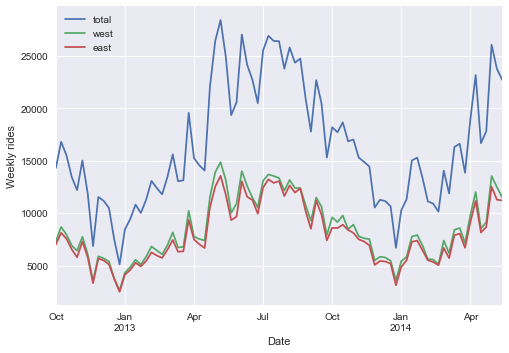

In [94]:
# A first look at the data

weekly.plot();
plt.ylabel('Weekly rides');

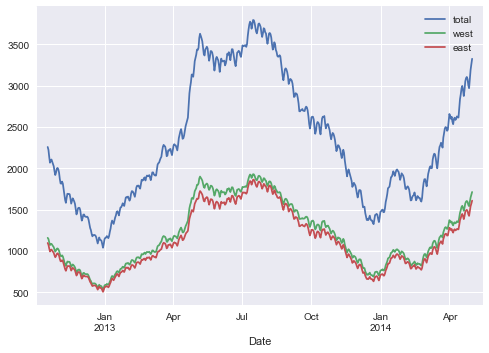

In [95]:
# Look at rolling weekly mean to smooth out short-term variation

data.resample('d').sum().rolling(30, center=True).mean().plot();

Blog post points out that 2014 has seen increased cycle traffic across the bridge. Below we're modelling seasonal variation based on what we think influences peoples' decision whether or not to ride a bike.

# Accounting for hours of daylight

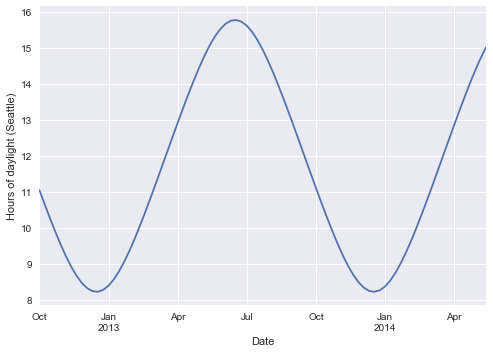

In [96]:
# Hours of daylight

from seattlecycling.tools import hours_of_daylight

weekly['daylight'] = list(map(hours_of_daylight, weekly.index))
daily['daylight'] = list(map(hours_of_daylight, daily.index))

weekly['daylight'].plot()
plt.ylabel('Hours of daylight (Seattle)');

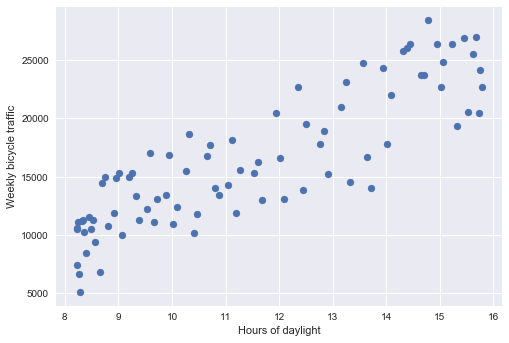

In [97]:
# Relationship between daylight and cycle traffic

plt.scatter(weekly.daylight, weekly.total)
plt.xlabel('Hours of daylight')
plt.ylabel('Weekly bicycle traffic');

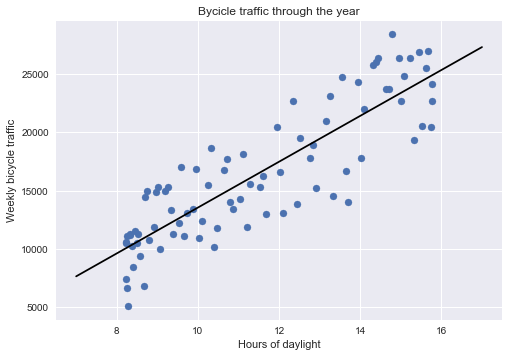

In [98]:
# Adding a linear trend

from sklearn.linear_model import LinearRegression

X = weekly[['daylight']]
y = weekly['total']
clf = LinearRegression(fit_intercept=True).fit(X, y)

weekly['daylight_trend'] = clf.predict(X)
weekly['daylight_corrected_total'] = weekly.total - weekly.daylight_trend + np.mean(weekly.daylight_trend)

xfit = np.linspace(7, 17)
yfit = clf.predict(xfit[:, None])

plt.scatter(weekly.daylight, weekly.total)
plt.plot(xfit, yfit, '-k')
plt.title('Bycicle traffic through the year')
plt.xlabel('Hours of daylight')
plt.ylabel('Weekly bicycle traffic');

In [99]:
clf.coef_[0]

1966.2003072317068

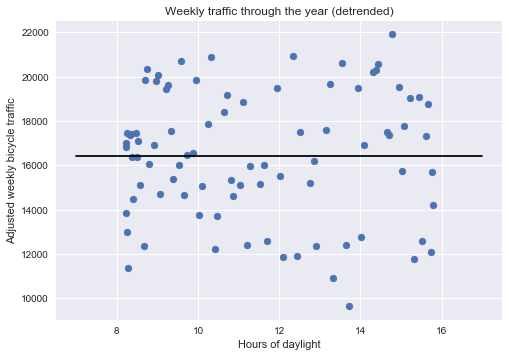

In [100]:
# Plot detrended data

trend = clf.predict(weekly[['daylight']].values)
plt.scatter(weekly.daylight, weekly.total - trend + np.mean(trend))
plt.plot(xfit, np.mean(trend) + 0 * yfit, '-k')
plt.title('Weekly traffic through the year (detrended)')
plt.xlabel('Hours of daylight')
plt.ylabel('Adjusted weekly bicycle traffic');

In the graph above, we have removed the number of riders per week that correlate with the number of hours of daylight, so that we can think of what is shown of the number of rides per week we'd expect to see if daylight was not an issue.

Root-mean-square about trend:  2872 riders


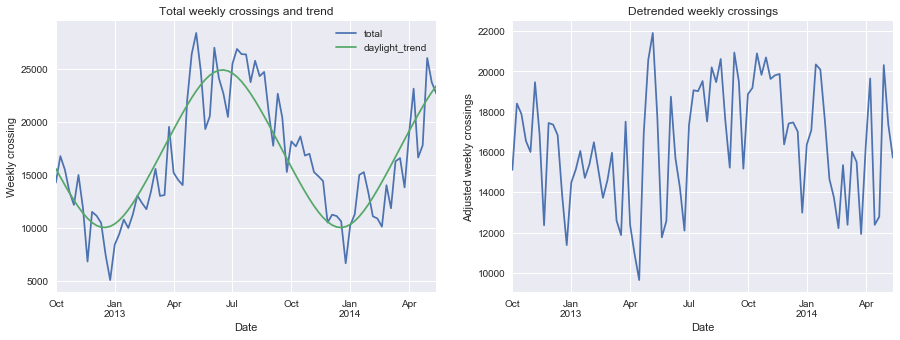

In [101]:
fix, ax = plt.subplots(1, 2, figsize=(15,5))

weekly[['total', 'daylight_trend']].plot(ax=ax[0])
weekly['daylight_corrected_total'].plot(ax=ax[1])

ax[0].set_ylabel('Weekly crossing')
ax[0].set_title('Total weekly crossings and trend')

ax[1].set_ylabel('Adjusted weekly crossings')
ax[1].set_title('Detrended weekly crossings')

rms = np.std(weekly['daylight_corrected_total'])
print('Root-mean-square about trend: {0: .0f} riders'.format(rms))

# Accounting for day of the week

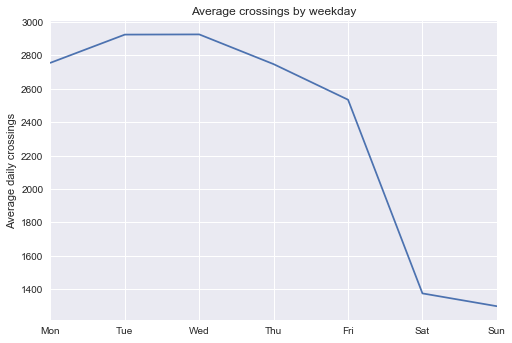

In [102]:
# Plot average number of trips by weekday

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily['dayofweek'] = daily['total'].index.dayofweek
grouped = daily.groupby('dayofweek')['total'].mean()
grouped.index = days

grouped.plot()
plt.title('Average crossings by weekday')
plt.ylabel('Average daily crossings');

In [103]:
# Account for hours of daylight and day of week simultaneously

# Add one-hot indicators of weekdays
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)
    
# Detrend on days of week and daylight together
X = daily[days + ['daylight']]
y = daily['total']
clf = LinearRegression().fit(X, y)

daily['dayofweek_trend'] = clf.predict(X)
daily['dayofweek_corrected'] = daily['total'] - daily['dayofweek_trend'] + daily['dayofweek_trend'].mean()

RMS =  652


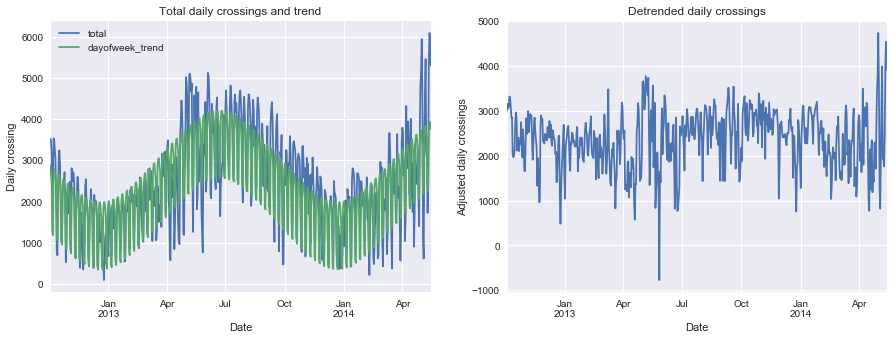

In [104]:
# Plot crossings and trend, and detrended data

fix, ax = plt.subplots(1, 2, figsize=(15,5))

daily[['total', 'dayofweek_trend']].plot(ax=ax[0])
daily['dayofweek_corrected'].plot(ax=ax[1])

ax[0].set_ylabel('Daily crossing')
ax[0].set_title('Total daily crossings and trend')
ax[1].set_ylabel('Adjusted daily crossings')
ax[1].set_title('Detrended daily crossings')

print('RMS = {0: .0f}'.format(np.std(daily['dayofweek_corrected'])))

# Accounting for rainfall and temparature

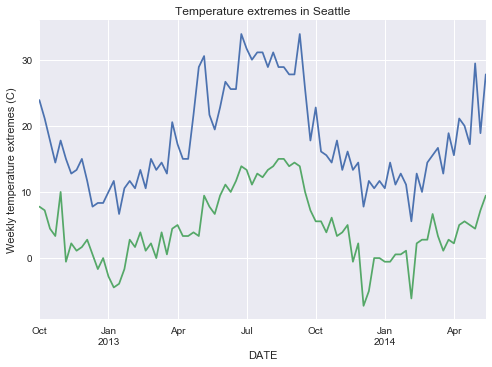

In [105]:
# Read in weather data
weather = pd.read_csv('SeaTacWeather.csv', index_col='DATE', 
                      parse_dates=True, usecols=[2, 5, 9, 10])
weather = weather.loc[start:end]
weather.columns = map(str.lower, weather.columns)

# Temparatures are in 1/10 deg F; convert to deg C
weather['tmax'] = (weather['tmax'] - 32) * 5/9
weather['tmin'] = (weather['tmin'] -32) * 5/9

# Rainfall is in inches; convert to mm
weather['prcp'] *= 25.4

weather['tmax'].resample('w').max().plot()
weather['tmin'].resample('w').min().plot()
plt.title('Temperature extremes in Seattle')
plt.ylabel('Weekly temperature extremes (C)');

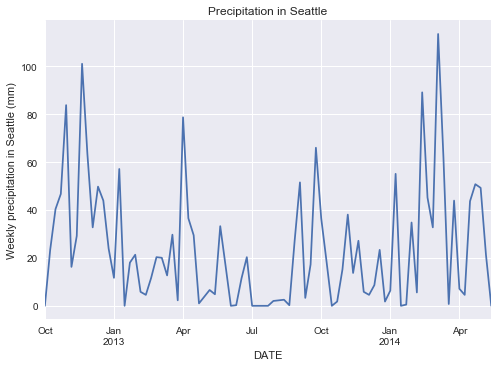

In [106]:
weather['prcp'].resample('w').sum().plot()
plt.title('Precipitation in Seattle')
plt.ylabel('Weekly precipitation in Seattle (mm)');

In [107]:
# Combine daily and weather dataset

daily = daily.join(weather)

In [108]:
# Detrend data including weather information

columns = days + ['daylight', 'tmax', 'tmin', 'prcp']
X = daily[columns]
y = daily['total']
clf = LinearRegression().fit(X, y)

daily['overall_trend'] = clf.predict(X)
daily['overall_corrected'] = daily['total'] - daily['overall_trend'] + daily['overall_trend'].mean()

RMS =  457


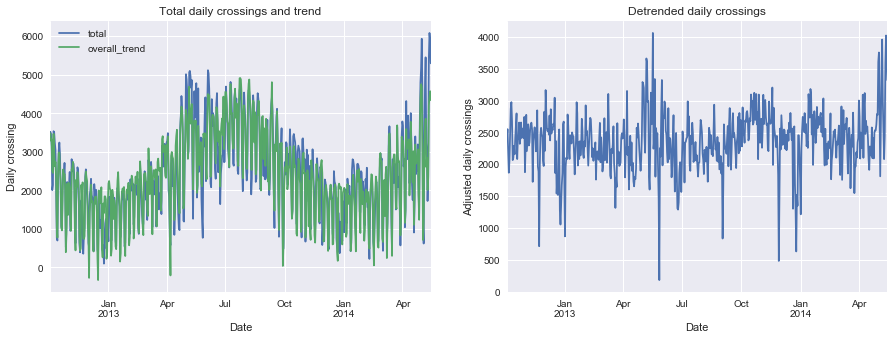

In [109]:
# Plot crossings and trend, and detrended data
fix, ax = plt.subplots(1, 2, figsize=(15,5))

daily[['total', 'overall_trend']].plot(ax=ax[0])
daily['overall_corrected'].plot(ax=ax[1])

ax[0].set_ylabel('Daily crossing')
ax[0].set_title('Total daily crossings and trend')
ax[1].set_ylabel('Adjusted daily crossings')
ax[1].set_title('Detrended daily crossings')

print('RMS = {0: .0f}'.format(np.std(daily['overall_corrected'])))

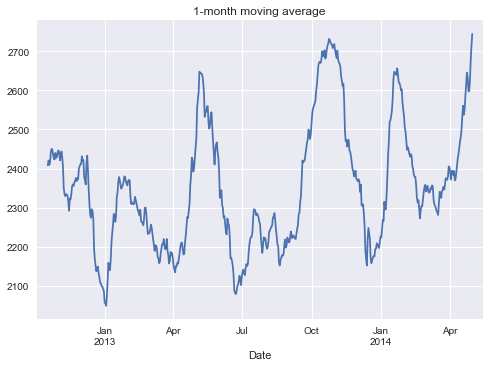

In [110]:
# Plot rolling 30 day average

daily['overall_corrected'].rolling(30, center=True).mean().plot();
plt.title('1-month moving average');

# Accounting for a steady increase in riders

In [111]:
daily['daycount'] = np.arange(len(daily))

columns = days + ['daycount', 'daylight', 'tmax', 'tmin', 'prcp']
X = daily[columns]
y = daily['total']
final_model = LinearRegression().fit(X, y)

daily['final_trend'] = final_model.predict(X)
daily['final_corrected'] = daily['total'] - daily['final_trend'] + daily['final_trend'].mean()

RMS =  451


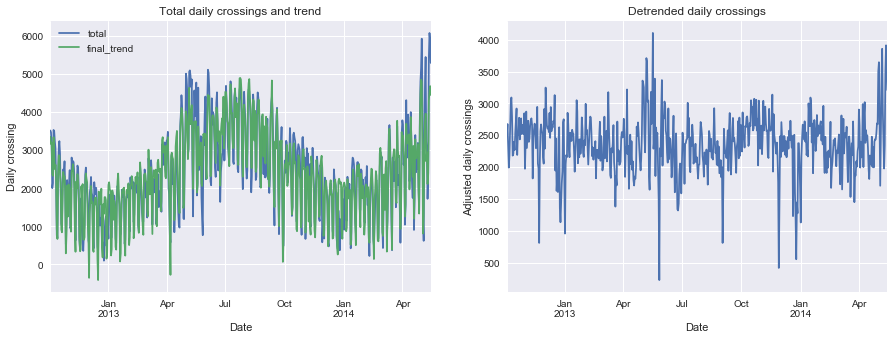

In [112]:
# Plot crossings and trend, and detrended data
fix, ax = plt.subplots(1, 2, figsize=(15,5))

daily[['total', 'final_trend']].plot(ax=ax[0])
daily['final_corrected'].plot(ax=ax[1])

ax[0].set_ylabel('Daily crossing')
ax[0].set_title('Total daily crossings and trend')
ax[1].set_ylabel('Adjusted daily crossings')
ax[1].set_title('Detrended daily crossings')

print('RMS = {0: .0f}'.format(np.std(daily['final_corrected'])))


# What can the final model tell us?

In [113]:
# Compute error variance

vy = np.sum((y - daily['final_trend']) ** 2) / len(y)
X2 = np.hstack([X, np.ones((X.shape[0], 1))])
C = vy * np.linalg.inv(np.dot(X2.T, X2))
C.diagonal()

array([7.98797229e+18, 7.98797229e+18, 7.98797229e+18, 7.98797229e+18,
       7.98797229e+18, 7.98797229e+18, 7.98797229e+18, 1.22344794e-02,
       1.48518661e+02, 4.16803724e+01, 6.21796956e+01, 7.68511409e+00,
       7.98797229e+18])

### How does rain affect ridership?

In [114]:
ind = columns.index('prcp')
slope = final_model.coef_[ind]
error = np.sqrt(var[ind])
print('{0: .0f} +/- {1: .0f} daily crossings lost per cm of rain'.format(-slope * 10, error * 10))

 331 +/-  29 daily crossings lost per cm of rain


The model shows that for every cm of rain, about 300 cyclists stay home or use another mode of transport.

### How does temparature affect ridership?

In [115]:
ind1, ind2 = columns.index('tmin'), columns.index('tmax')
slope = final_model.coef_[ind1] + final_model.coef_[ind2]
error = np.sqrt(var[ind1] + var[ind2])
print('{0:.0f} +/- {1:.0f} riders per ten degrees Celsius'.format(10 * slope, 10 * error))

493 +/- 106 riders per ten degrees Celsius


### How does daylight affect ridership?

In [116]:
ind = columns.index('daylight')
slopt = final_model.coef_[ind]
error = np.sqrt(var[ind])
print('{0:.0f} +/- {1:.0f} riders per hour of daylight'.format(slope, error))

49 +/- 13 riders per hour of daylight


### Is ridership increasing?

In [117]:
ind = columns.index('daycount')
slope = final_model.coef_[ind]
error = np.sqrt(var[ind])
print("{0:.2f} +/- {1:.2f} new riders per day".format(slope, error))
print("{0:.1f} +/- {1:.1f} new riders per week".format(7 * slope, 7 * error))
print("annual change: ({0:.0f} +/- {1:.0f})%".format(100 * 365 * slope / daily['total'].mean(),
                                                    100 * 365 * error / daily['total'].mean()))

0.43 +/- 0.11 new riders per day
3.0 +/- 0.8 new riders per week
annual change: (7 +/- 2)%
